In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import mpmp.config as cfg
import mpmp.utilities.analysis_utilities as au
import mpmp.utilities.plot_utilities as plu

%load_ext autoreload
%autoreload 2

In [2]:
# set results directory
drop_results_dir = Path(cfg.results_dirs['mutation'],
                        'dosage_effects',
                        'drop_target',
                        'gene')

control_results_dir = Path(cfg.results_dirs['mutation'],
                           'shuffle_cancer_type',
                           'expression_vogelstein',
                           'gene')

In [3]:
drop_results_df = au.load_stratified_prediction_results(drop_results_dir, 'gene')
drop_results_df['experiment'] = 'drop_target'
drop_results_df = (drop_results_df
    .drop(columns='training_data')
    .rename(columns={'experiment': 'training_data'})
)

print(drop_results_df.shape)
drop_results_df.head()

(4032, 8)


,auroc,aupr,identifier,signal,seed,data_type,fold,training_data
0,0.99984,0.99847,MAP3K1,signal,42,train,0,drop_target
1,0.75289,0.44210,MAP3K1,signal,42,test,0,drop_target
2,0.67790,0.30396,MAP3K1,signal,42,cv,0,drop_target
3,0.99944,0.99409,MAP3K1,signal,42,train,1,drop_target
4,0.66980,0.42028,MAP3K1,signal,42,test,1,drop_target


In [4]:
control_results_df = au.load_stratified_prediction_results(control_results_dir, 'gene')
control_results_df['experiment'] = 'control'
control_results_df = (control_results_df
    .drop(columns='training_data')
    .rename(columns={'experiment': 'training_data'})
)

print(control_results_df.shape)
control_results_df.head()

In [12]:
compare_results_df = au.compare_results(control_results_df,
                                        condition_2_df=drop_results_df,
                                        identifier='identifier',
                                        metric='aupr',
                                        correction=True,
                                        correction_method='fdr_bh',
                                        correction_alpha=0.05,
                                        verbose=True)
compare_results_df['nlog10_p'] = -np.log10(compare_results_df.corr_pval)
print(compare_results_df.shape)
compare_results_df.sort_values(by='corr_pval').head()

(84, 6)


,identifier,delta_mean,p_value,corr_pval,reject_null,nlog10_p
36,ERBB2,-0.022204,0.003756,0.105179,False,0.978073
16,CDKN2A,-0.014236,0.002916,0.105179,False,0.978073
54,SMAD4,-0.068752,0.003189,0.105179,False,0.978073
0,EGFR,-0.035507,0.007246,0.152160,False,0.817698
27,PTEN,-0.033502,0.015411,0.215754,False,0.666042


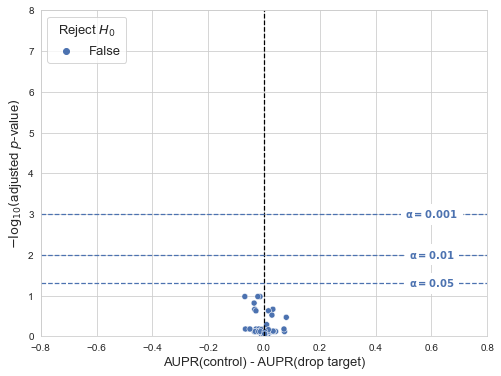

In [28]:
sns.set({'figure.figsize': (8, 6)})
sns.set_style('whitegrid')

ax = plt.gca()

plt.xlim(-0.8, 0.8)
plt.ylim(0, 8)

# add vertical line at 0
ax.axvline(x=0, linestyle='--', linewidth=1.25, color='black')

for alpha in [0.05, 0.01, 0.001]:
    # add horizontal line at statistical significance threshold
    l = ax.axhline(y=-np.log10(alpha), linestyle='--', linewidth=1.25)

    # label horizontal line with significance threshold
    # (matplotlib makes this fairly difficult, sadly)
    ax.text(0.6, -np.log10(alpha)+0.01,
            r'$\mathbf{{\alpha = {}}}$'.format(alpha),
            va='center', ha='center', color=l.get_color(),
            backgroundcolor=ax.get_facecolor())

sns.scatterplot(data=compare_results_df,
                x='delta_mean',
                y='nlog10_p',
                hue='reject_null')

plt.xlabel('AUPR(control) - AUPR(drop target)', size=13)
plt.ylabel(r'$-\log_{10}($adjusted $p$-value$)$', size=13)
plt.legend(title=r'Reject $H_0$', loc='upper left',
           fontsize=13, title_fontsize=13)